# All required imports and setting up constants

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras import Input
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SEED_CONSTANT= 42
np.random.seed(SEED_CONSTANT)
tf.random.set_seed(SEED_CONSTANT)

DATASET_DIR = '/content/drive/MyDrive/Colab Notebooks/hmdb51'
#SELECTED_ACTIONS = ['clap', 'climb_stairs', 'drink', 'eat', 'fall_floor', 'jump', 'run', 'shake_hands', 'sit', 'stand', 'walk', 'wave']
SELECTED_ACTIONS = ['climb_stairs', 'jump', 'run', 'sit', 'stand', 'wave']

VIDEO_WIDTH= 80 # Min width is 320
VIDEO_HEIGHT= 60 # All video have same height of 240
MAX_FRAMES= 20 # Maximum of 30 frames from each video

# Visualise the data and Categories available

climb_stairs = 112
Minimum video resolution 240.0x288.0
Maximum video resolution 240.0x576.0
Minimum video duration 1.2
Maximum video duration 5.833333333333333

jump = 151
Minimum video resolution 240.0x320.0
Maximum video resolution 240.0x592.0
Minimum video duration 0.7333333333333333
Maximum video duration 5.633333333333334

run = 232
Minimum video resolution 240.0x304.0
Maximum video resolution 240.0x592.0
Minimum video duration 0.7333333333333333
Maximum video duration 9.633333333333333

sit = 142
Minimum video resolution 240.0x304.0
Maximum video resolution 240.0x592.0
Minimum video duration 0.8
Maximum video duration 6.766666666666667

stand = 154
Minimum video resolution 240.0x320.0
Maximum video resolution 240.0x592.0
Minimum video duration 0.8333333333333334
Maximum video duration 9.466666666666667

wave = 104
Minimum video resolution 240.0x288.0
Maximum video resolution 240.0x560.0
Minimum video duration 0.8
Maximum video duration 6.866666666666666



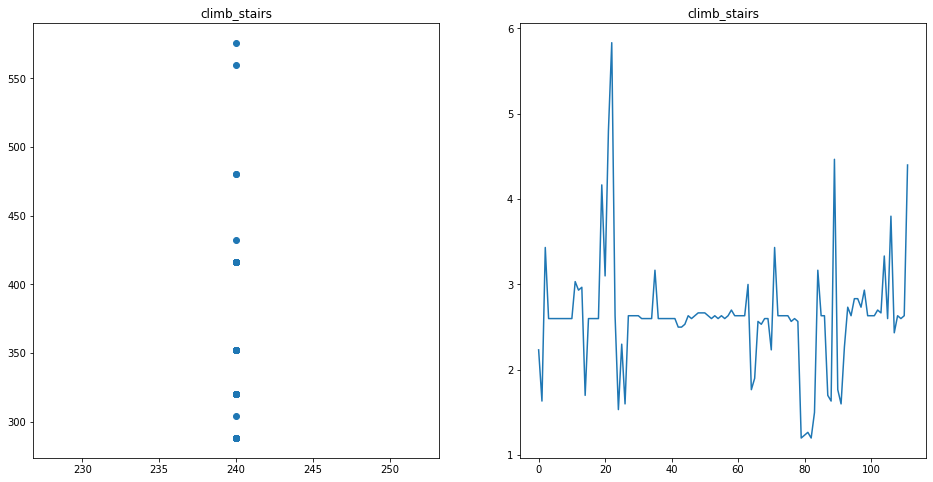

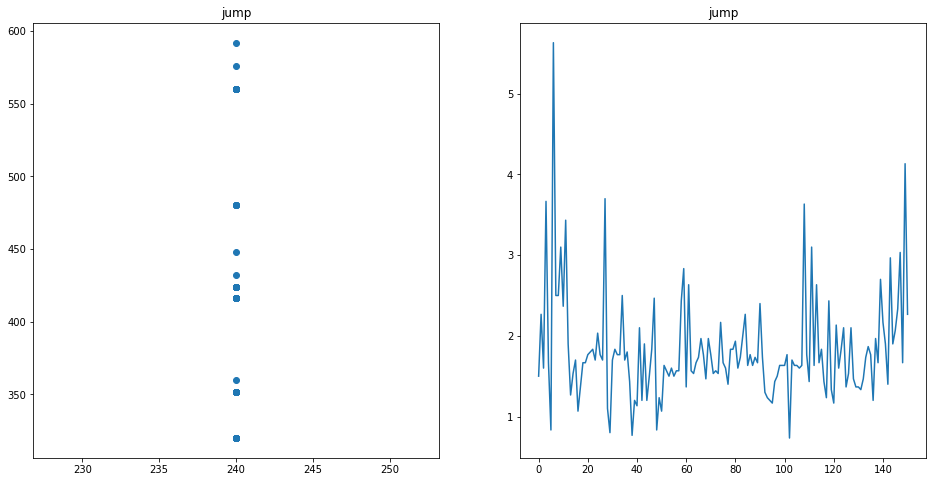

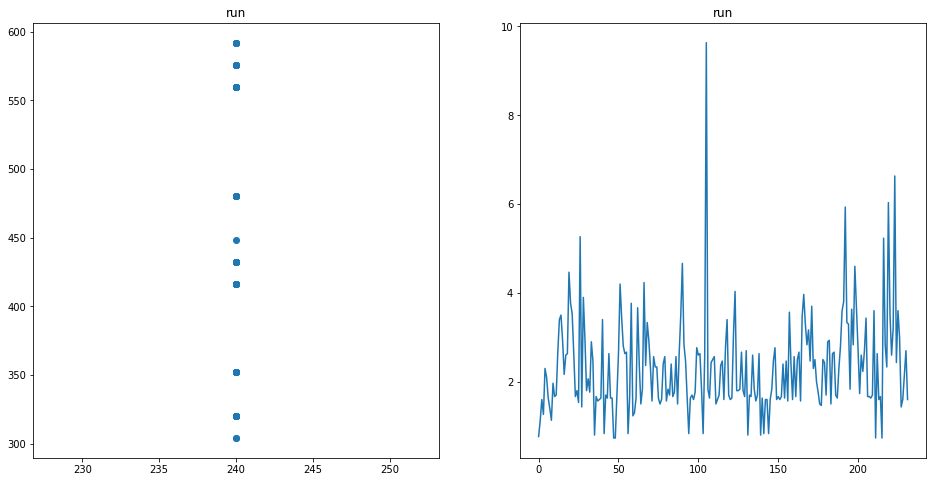

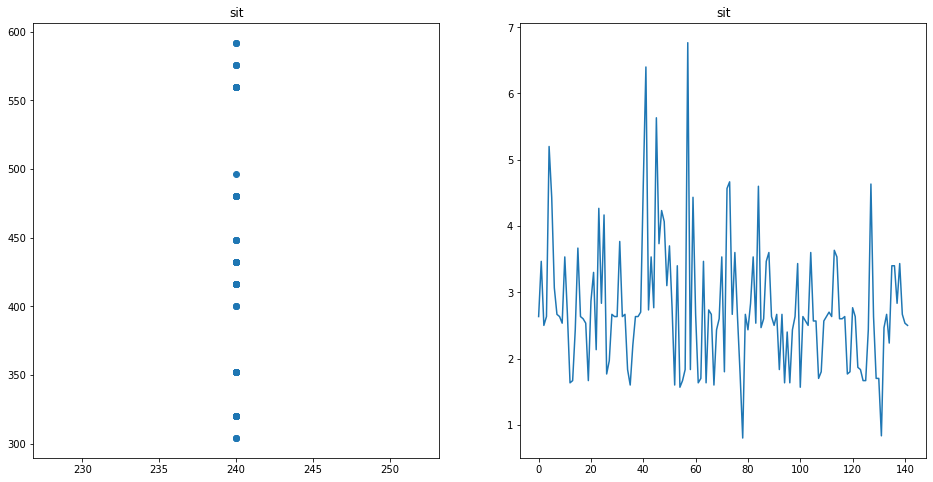

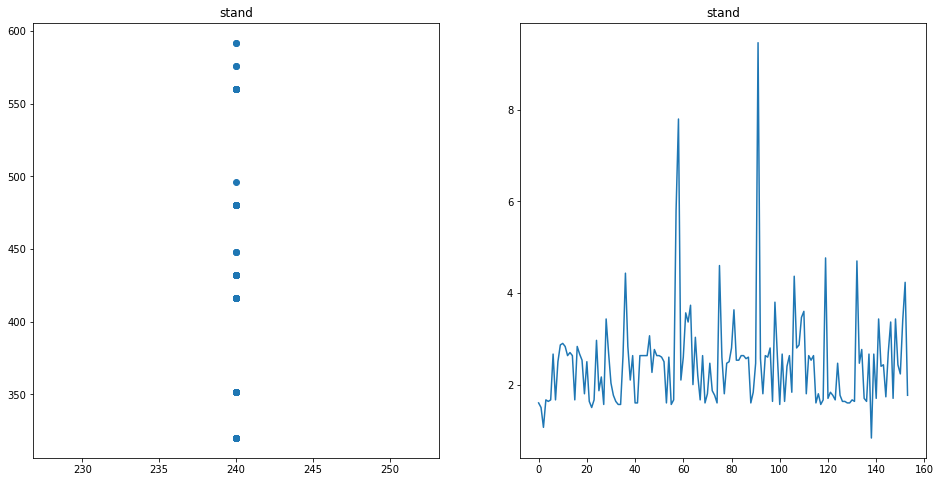

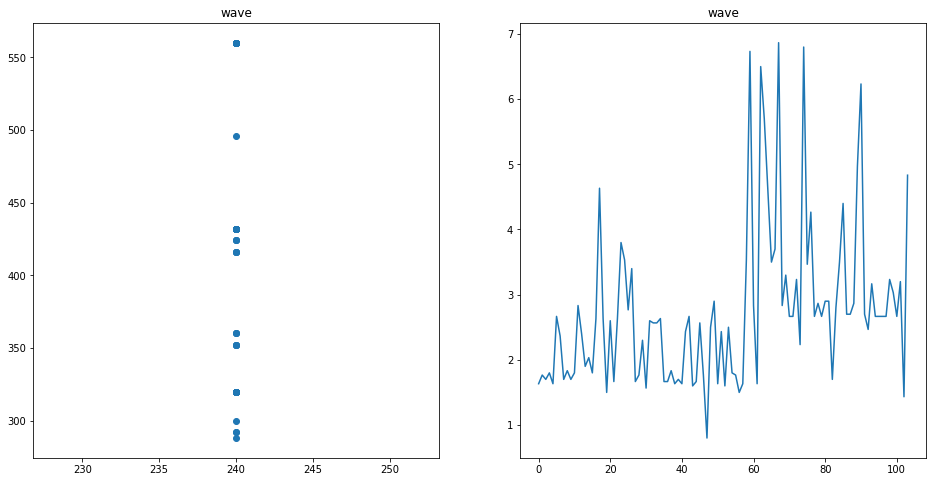

In [ ]:
for currentAction in SELECTED_ACTIONS:
    videos = os.listdir(f'{DATASET_DIR}/{currentAction}/{currentAction}')
    
    videoWidths= []
    videoHeights= []
    videoDurations= []
    # videoFPS= [] all videos are 30 FPS
    for vid in videos:
        cap = cv2.VideoCapture(f'{DATASET_DIR}/{currentAction}/{currentAction}/{vid}')
        videoWidths.append(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        videoHeights.append(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        videoDurations.append(cap.get(cv2.CAP_PROP_FRAME_COUNT)/cap.get(cv2.CAP_PROP_FPS))
        # videoFPS.append(cap.get(cv2.CAP_PROP_FPS))
        cap.release()
    
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.scatter(videoHeights, videoWidths)
    plt.title(currentAction)
    plt.subplot(122)
    plt.plot(videoDurations)
    plt.title(currentAction)

    print(currentAction, f'= {len(videoDurations)}')
    print(f'Minimum video resolution {min(videoHeights)}x{min(videoWidths)}')
    print(f'Maximum video resolution {max(videoHeights)}x{max(videoWidths)}')
    print(f'Minimum video duration {min(videoDurations)}')
    print(f'Maximum video duration {max(videoDurations)}', end='\n\n')

# Extract frames from video files and create dataset

In [ ]:
def frameExtraction(videoPath):
    frames= []
    cap= cv2.VideoCapture(videoPath)

    frameCount= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameSkipInterval= max(int(frameCount/MAX_FRAMES), 1)

    for count in range(MAX_FRAMES):
        cap.set(cv2.CAP_PROP_POS_FRAMES, count*frameSkipInterval)
        success, frame = cap.read()
        
        if not success:
            break

        resizedFrame= cv2.resize(frame, (VIDEO_HEIGHT, VIDEO_WIDTH))
        # To normalize the RGB values of each pixel between 0-1
        normalizedFrame= resizedFrame/255
        frames.append(normalizedFrame)

    cap.release()
    return frames

In [ ]:
def createDataset():
    features= []
    labels= []

    for action in SELECTED_ACTIONS:
        print(f'Extracting data of action: {action}')
        videoDir= os.listdir(os.path.join(DATASET_DIR, action, action))

        for video in videoDir:
            filePath= os.path.join(DATASET_DIR, action, action, video)
            frames= frameExtraction(filePath)

            if len(frames) == MAX_FRAMES:
                features.append(frames)
                labels.append(action)
    
    features= np.asarray(features)
    labels= np.array(labels)

    return features, labels

In [ ]:
features, labels= createDataset()

Extracting data of action: climb_stairs
Extracting data of action: jump
Extracting data of action: run
Extracting data of action: sit
Extracting data of action: stand
Extracting data of action: wave


# Preprocessing categorical data and splitting dataset

In [ ]:
oneHotLabels= OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1, 1))
print(oneHotLabels)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [ ]:
X_train, X_test, y_train, y_test= train_test_split(features, oneHotLabels, test_size=0.25, shuffle=True, random_state=SEED_CONSTANT)

In [ ]:
print(np.shape(features))
print(np.shape(X_train))
print(np.shape(y_train))

(895, 20, 80, 60, 3)
(671, 20, 80, 60, 3)
(671, 6)


#Create Models and evaluate

## General purpose functions and callbacks

In [ ]:
def plotMetric(model_training_history, metric1, metric2, plot_name):
  metric1_value= model_training_history.history[metric1]
  metric2_value= model_training_history.history[metric2]

  epochs= range(len(metric1_value))

  plt.plot(epochs, metric1_value, 'blue', label=metric1)
  plt.plot(epochs, metric2_value, 'red', label=metric2)

  plt.title(plot_name)
  plt.legend()

earlyStoppingCallback= EarlyStopping(monitor='val_accuracy', patience= 8, mode='max', restore_best_weights=True)
earlyStoppingCallback2= EarlyStopping(monitor='val_loss', patience= 8, mode='min', restore_best_weights=True)
reduceLRCallback= ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, mode='min')

## ConvLSTM2D Model

In [ ]:
def createConvLSTM2D():

    model = Sequential()

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (MAX_FRAMES, VIDEO_WIDTH, VIDEO_HEIGHT, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(SELECTED_ACTIONS), activation = "softmax"))
    

    model.summary()
    return model

In [ ]:
convlstm2d_model= createConvLSTM2D()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_27 (ConvLSTM2D)  (None, 20, 78, 58, 8)    3200      
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 20, 39, 29, 8)    0         
 g3D)                                                            
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 39, 29, 8)    0         
 stributed)                                                      
                                                                 
 conv_lstm2d_28 (ConvLSTM2D)  (None, 20, 37, 27, 16)   13888     
                                                                 
 max_pooling3d_27 (MaxPoolin  (None, 20, 19, 14, 16)   0         
 g3D)                                                            
                                                      

In [ ]:
convlstm2d_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

convlstm2d_model_training= convlstm2d_model.fit(x= X_train, y= y_train, epochs= 50, batch_size= 6, shuffle= True, validation_split= 0.2, callbacks=[earlyStoppingCallback])

Epoch 1/50
90/90 [==============================] - 61s 560ms/step - loss: 1.7890 - accuracy: 0.1866 - val_loss: 1.7864 - val_accuracy: 0.2815
Epoch 2/50
90/90 [==============================] - 49s 548ms/step - loss: 1.7658 - accuracy: 0.2444 - val_loss: 1.7197 - val_accuracy: 0.2889
Epoch 3/50
90/90 [==============================] - 50s 551ms/step - loss: 1.7293 - accuracy: 0.3004 - val_loss: 1.6816 - val_accuracy: 0.2815
Epoch 4/50
90/90 [==============================] - 50s 551ms/step - loss: 1.7144 - accuracy: 0.2817 - val_loss: 1.6010 - val_accuracy: 0.3556
Epoch 5/50
90/90 [==============================] - 49s 548ms/step - loss: 1.5991 - accuracy: 0.3451 - val_loss: 1.6257 - val_accuracy: 0.3111
Epoch 6/50
90/90 [==============================] - 49s 548ms/step - loss: 1.5087 - accuracy: 0.4104 - val_loss: 1.5382 - val_accuracy: 0.3704
Epoch 7/50
90/90 [==============================] - 49s 549ms/step - loss: 1.3774 - accuracy: 0.4664 - val_loss: 1.4880 - val_accuracy: 0.4074

In [ ]:
model_loss, model_accuracy= convlstm2d_model.evaluate(X_test, y_test)

7/7 [==============================] - 2s 154ms/step - loss: 1.6439 - accuracy: 0.4152


In [ ]:
model_file_name= f'convlstm2d_model__loss_{model_loss}__accuracy_{model_accuracy}.h5'
convlstm2d_model.save(model_file_name)

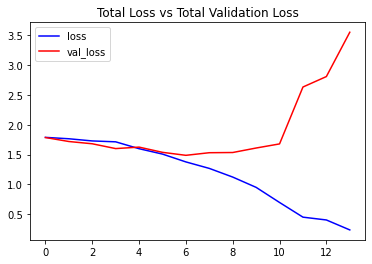

In [ ]:
plotMetric(convlstm2d_model_training, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

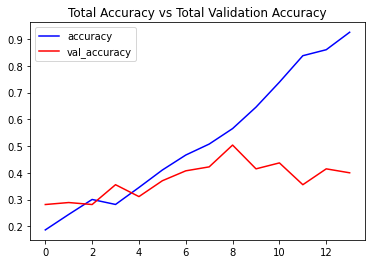

In [ ]:
plotMetric(convlstm2d_model_training, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## LRCN Model

In [ ]:
def createLRCN():

    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, 3, padding='same',activation = 'relu'),
                              input_shape = (MAX_FRAMES, VIDEO_WIDTH, VIDEO_HEIGHT, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((6, 6)))) 
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(32, 3, padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(64, 3, padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    
    model.add(TimeDistributed(Conv2D(128, 3, padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((1, 1))))
    model.add(TimeDistributed(Dropout(0.3)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(40))
                                      
    model.add(Dense(len(SELECTED_ACTIONS), activation = 'softmax'))
 
    model.summary()
    return model

In [ ]:
lrcn_model= createLRCN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 80, 60, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 13, 10, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 13, 10, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 13, 10, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 3, 2, 32)     0

In [ ]:
lrcn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lrcn_model_training = lrcn_model.fit(x = X_train, y = y_train, epochs = 70, batch_size = 6, shuffle = True, validation_split = 0.2, callbacks=[earlyStoppingCallback2])

Epoch 1/70
90/90 [==============================] - 14s 27ms/step - loss: 1.7807 - accuracy: 0.2201 - val_loss: 1.7775 - val_accuracy: 0.1778
Epoch 2/70
90/90 [==============================] - 1s 15ms/step - loss: 1.7727 - accuracy: 0.1978 - val_loss: 1.7584 - val_accuracy: 0.3037
Epoch 3/70
90/90 [==============================] - 1s 15ms/step - loss: 1.7562 - accuracy: 0.2369 - val_loss: 1.7218 - val_accuracy: 0.2741
Epoch 4/70
90/90 [==============================] - 1s 15ms/step - loss: 1.7063 - accuracy: 0.2799 - val_loss: 1.7311 - val_accuracy: 0.3111
Epoch 5/70
90/90 [==============================] - 1s 15ms/step - loss: 1.6903 - accuracy: 0.2575 - val_loss: 1.6603 - val_accuracy: 0.3259
Epoch 6/70
90/90 [==============================] - 1s 15ms/step - loss: 1.6391 - accuracy: 0.3172 - val_loss: 1.6981 - val_accuracy: 0.3630
Epoch 7/70
90/90 [==============================] - 1s 15ms/step - loss: 1.6077 - accuracy: 0.3041 - val_loss: 1.6403 - val_accuracy: 0.3037
Epoch 8/70
9

In [ ]:
model_loss, model_accuracy= lrcn_model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 25ms/step - loss: 1.4625 - accuracy: 0.4241


In [ ]:
model_file_name= f'lrcn_model__loss_{model_loss}__accuracy_{model_accuracy}.h5'
lrcn_model.save(model_file_name)

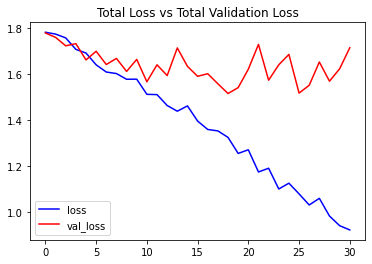

In [ ]:
plotMetric(lrcn_model_training, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

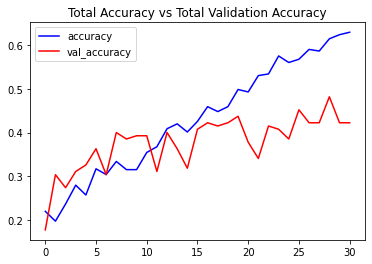

In [ ]:
plotMetric(lrcn_model_training, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## Concatenated RNN + CNN model

In [ ]:
def addResidualLayer(model, filters):
  start_block= model
  model= Conv2D(filters=filters, kernel_size=3, padding='same')(model)
  model= BatchNormalization(momentum=0.9)(model)
  model= LeakyReLU(0.2)(model)
  return concatenate([start_block, model])

def createConcatenatedRNN():
  input_layer= Input(shape=(MAX_FRAMES, VIDEO_WIDTH, VIDEO_HEIGHT, 3))

  model= ConvLSTM2D(32, 3, padding='same', return_sequences= False)(input_layer)
  model= BatchNormalization(momentum=0.9)(model)
  model= LeakyReLU(0.2)(model)

  filters= 64

  for _ in range(6):
    model= addResidualLayer(model, filters)
    try:
      model= MaxPooling2D((3,3))(model)
    except:
      model= MaxPooling2D((1,1))(model)

    if filters < 512:
      filters *= 2

  model= Flatten()(model)
  #model= LSTM(40)(model)
  model= Dense(len(SELECTED_ACTIONS), activation='softmax')(model)
  model= Model(input_layer, model)

  model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  model.summary()
  return model

In [ ]:
concatenatedRNN_model= createConcatenatedRNN()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 20, 80, 60,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_lstm2d_7 (ConvLSTM2D)     (None, 80, 60, 32)   40448       ['input_8[0][0]']                
                                                                                                  
 batch_normalization_49 (BatchN  (None, 80, 60, 32)  128         ['conv_lstm2d_7[0][0]']          
 ormalization)                                                                                    
                                                                                            

In [ ]:
concatenatedRNN_model_training= concatenatedRNN_model.fit(x= X_train, y= y_train, epochs= 100, batch_size= 6, shuffle= True, validation_split= 0.2, callbacks=[earlyStoppingCallback2])

Epoch 1/100
90/90 [==============================] - 24s 220ms/step - loss: 2.6623 - accuracy: 0.2537 - val_loss: 1.5700 - val_accuracy: 0.3407
Epoch 2/100
90/90 [==============================] - 18s 201ms/step - loss: 1.6578 - accuracy: 0.3862 - val_loss: 1.7963 - val_accuracy: 0.4074
Epoch 3/100
90/90 [==============================] - 18s 206ms/step - loss: 1.3578 - accuracy: 0.4963 - val_loss: 1.5814 - val_accuracy: 0.4370
Epoch 4/100
90/90 [==============================] - 18s 198ms/step - loss: 1.0387 - accuracy: 0.6269 - val_loss: 1.5525 - val_accuracy: 0.4519
Epoch 5/100
90/90 [==============================] - 18s 196ms/step - loss: 0.8245 - accuracy: 0.7201 - val_loss: 1.9716 - val_accuracy: 0.3556
Epoch 6/100
90/90 [==============================] - 18s 198ms/step - loss: 0.6566 - accuracy: 0.7873 - val_loss: 1.6769 - val_accuracy: 0.4667
Epoch 7/100
90/90 [==============================] - 18s 199ms/step - loss: 0.5140 - accuracy: 0.8507 - val_loss: 1.7797 - val_accuracy:

In [ ]:
model_loss, model_accuracy= concatenatedRNN_model.evaluate(X_test, y_test)

7/7 [==============================] - 2s 208ms/step - loss: 1.9096 - accuracy: 0.4821


In [ ]:
model_file_name= f'concatenatedRNN_model__loss_{model_loss}__accuracy_{model_accuracy}.h5'
concatenatedRNN_model.save(model_file_name)

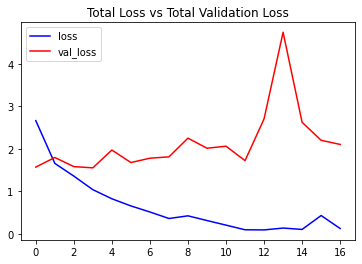

In [ ]:
plotMetric(concatenatedRNN_model_training, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

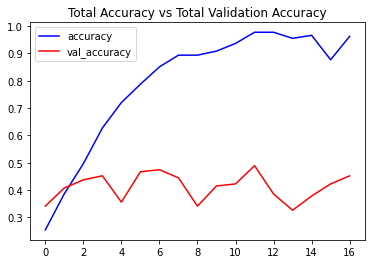

In [ ]:
plotMetric(concatenatedRNN_model_training, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')